# Simple Policy Optimization
Notebook for trying out the tooling involved in using policy gradient methods to train a model on SpaceInvaders.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import gym
import matplotlib.pyplot as plt
tfd = tfp.distributions
%matplotlib inline

In [2]:
import os
if os.environ.get("DISPLAY") is str and len(os.environ.get("DISPLAY"))!=0:
    !bash ../xvfb start
    %env DISPLAY=:1
# !pip install gym[box2d]

In [3]:
tf.__version__

'2.1.0'

In [4]:
tf.executing_eagerly()

True

In [5]:
tfp.__version__

'0.9.0'

# Create Car Racing environment 

In [6]:
env_name = 'CarRacing-v0' # 'SpaceInvaders-v0'
env = gym.make(env_name)

In [7]:
env.observation_space

Box(96, 96, 3)

In [8]:
env.observation_space.shape

(96, 96, 3)

In [9]:
env.action_space

Box(3,)

Track generation: 1135..1423 -> 288-tiles track


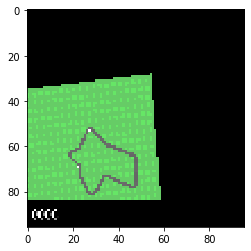

In [10]:
_ = plt.imshow(env.reset())

In [12]:
env.action_space.low, env.action_space.high

(array([-1.,  0.,  0.], dtype=float32), array([1., 1., 1.], dtype=float32))

In [13]:
# Sampling from action space randomly
# tfd.Multinomial(total_count=1, logits=[-1.] * env.action_space.n).sample(1)
env.action_space.sample()

array([0.14486402, 0.44344798, 0.16793524], dtype=float32)

# Next step: create h x w x n_frame tensor 
We can implement sequence of frames by allocating an initial h x w x n_frame tensor and for each new frame
rolling the tensor along axis 2 then assigning the new frame to channel 0. Is there a better or more idiomatic way to do this?
Could concatenate each new frame onto buffer.

In [14]:
buffer = tf.zeros((4,) + env.observation_space.shape, dtype=tf.uint8)

In [15]:
buffer.shape

TensorShape([4, 96, 96, 3])

In [36]:
network = tf.keras.models.Sequential()
network.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=buffer.shape[1:]))
network.add(tf.keras.layers.MaxPooling2D((2,2)))
network.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
network.add(tf.keras.layers.MaxPooling2D((2,2)))
network.add(tf.keras.layers.Flatten())
network.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 30976)             0         
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________


In [37]:
# f = plt.figure()
for i in range(10):
    obs, reward, done, info = env.step(env.action_space.sample())
    updated_buffer = tf.concat([obs[tf.newaxis, ...], buffer[:-1, ...]], axis=0)
    buffer = updated_buffer
#     _ = plt.imshow(buffer[0, ...])
#     plt.show()

In [38]:
network.build()

In [39]:
network(buffer.numpy().astype('float32'))

<tf.Tensor: shape=(4, 30976), dtype=float32, numpy=
array([[ 0.      ,  0.      , 45.091606, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      , 35.083214, ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      , 26.21489 , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      , 26.188221, ...,  0.      ,  0.      ,
         0.      ]], dtype=float32)>